# PCA


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/1006/MASTER_VARIABLES.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df

,object_id,district,rc_area,timeperiod,total_tender_awarded_value,SOPD_tenders_awarded_value,SDRF_tenders_awarded_value,RIDF_tenders_awarded_value,LTIF_tenders_awarded_value,CIDF_tenders_awarded_value,...,mean_cn,elevation_mean,slope_mean,net_sown_area_in_hac,avg_electricity,avg_tele,rc_piped_hhds_pct,rc_nosanitation_hhds_pct,distance_from_river,drainage_density
0,101,KOKRAJHAR,1069,2021_05,17884047.70,0.0,0.00,0.00,0,0.0,...,76.369986,78.792197,2.387460,32583.05,6.095781,2,0.937283,20.164813,1718.766638,0.000542
1,101,KOKRAJHAR,1069,2021_06,23957462.01,8544502.0,9957710.23,0.00,0,0.0,...,76.369986,78.792197,2.387460,32583.05,6.095781,2,0.937283,20.164813,1718.766638,0.000542
2,101,KOKRAJHAR,1069,2021_07,22246865.21,0.0,0.00,9926893.93,0,0.0,...,76.369986,78.792197,2.387460,32583.05,6.095781,2,0.937283,20.164813,1718.766638,0.000542
3,101,KOKRAJHAR,1069,2021_08,7991730.00,0.0,7991730.00,0.00,0,0.0,...,76.369986,78.792197,2.387460,32583.05,6.095781,2,0.937283,20.164813,1718.766638,0.000542
4,101,KOKRAJHAR,1069,2021_09,0.00,0.0,0.00,0.00,0,0.0,...,76.369986,78.792197,2.387460,32583.05,6.095781,2,0.937283,20.164813,1718.766638,0.000542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,281,MAJULI,648,2023_04,0.00,0.0,0.00,0.00,0,0.0,...,127.054751,83.727276,2.595149,10909.71,9.435180,2,7.813776,6.202922,822.878713,0.000629
5036,281,MAJULI,648,2023_05,0.00,0.0,0.00,0.00,0,0.0,...,127.054751,83.727276,2.595149,10909.71,9.435180,2,7.813776,6.202922,822.878713,0.000629
5037,281,MAJULI,648,2023_06,0.00,0.0,0.00,0.00,0,0.0,...,127.054751,83.727276,2.595149,10909.71,9.435180,2,7.813776,6.202922,822.878713,0.000629
5038,281,MAJULI,648,2023_07,0.00,0.0,0.00,0.00,0,0.0,...,127.054751,83.727276,2.595149,10909.71,9.435180,2,7.813776,6.202922,822.878713,0.000629


In [4]:
#cumulate by year or all inclusive
def rolling_cumulate(data, columns_to_cumulate, month=3):
    """
    Calculate a rolling cumulative sum of the given columns over a window of months and for each object_id.

    Parameters:
    - data: Input dataframe
    - columns_to_cumulate: List of column names to cumulate
    - month: Number of months for the rolling window (default is 3)

    Returns:
    - Processed dataframe
    """
    # Extract year and month
    data['year'] = data['timeperiod'].str.split('_').str[0].astype(int)
    data['month'] = data['timeperiod'].str.split('_').str[1].astype(int)

    # Ensure data is sorted by object_id and time
    data = data.sort_values(by=['object_id', 'year', 'month'])

    # Calculate the rolling cumulative sum for each column
    for column in columns_to_cumulate:
        data[column + '_cum_'+ str(month)] = data.groupby('object_id')[column].rolling(window=month, min_periods=1).sum().reset_index(0, drop=True)

    # Drop temporary columns
    data = data.drop(columns=['year', 'month'])

    return data

In [5]:
# Explore the correlations and apply PCA
# For each variable, select top 20 most correlated variables and sort them
top_20_correlations = {}
df_numeric = df.drop(columns = ['object_id','district','rc_area','timeperiod'])
correlation_matrix = df_numeric.corr()

for column in df_numeric.columns:
    # Sorting correlations in descending order (excluding the variable itself) and taking the top 20
    sorted_correlations = correlation_matrix[column].drop(column).sort_values(ascending=False).head(20)
    top_20_correlations[column] = sorted_correlations

<Axes: >

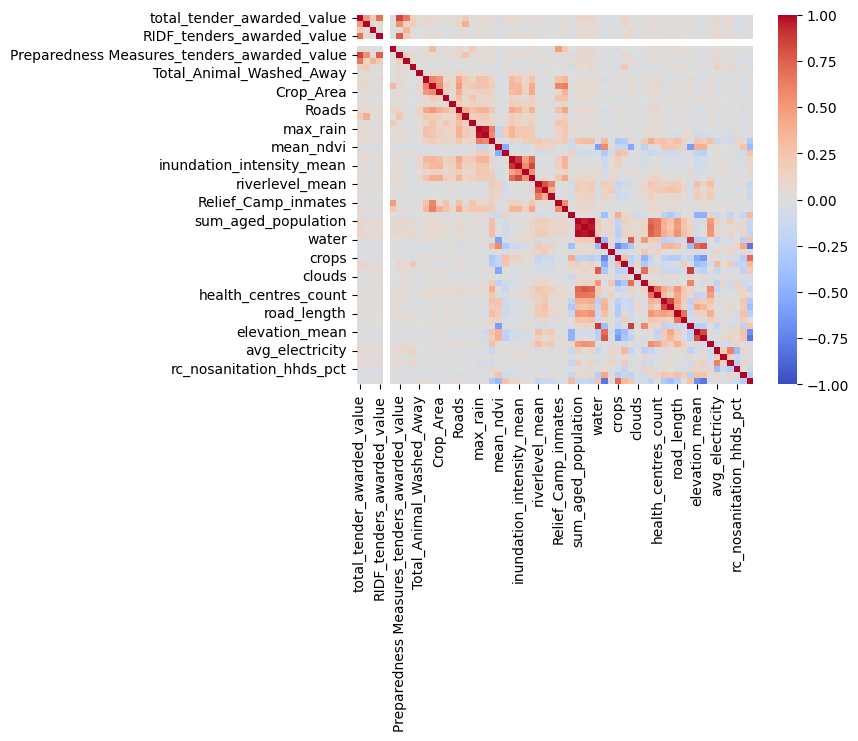

In [6]:
sns.heatmap(df_numeric.corr(), cmap='coolwarm', vmin=-1, vmax=1)

In [7]:
top_20_correlations['Population_affected_Total']

Human_Live_Lost                      0.624623
Total_Animal_Affected                0.604370
Relief_Camp_inmates                  0.588977
Crop_Area                            0.570607
Roads                                0.495365
inundation_intensity_sum             0.402819
inundation_pct                       0.355335
inundation_intensity_mean            0.331990
CIDF_tenders_awarded_value           0.320443
max_rain                             0.249650
mean_rain                            0.247354
Embankment breached                  0.234484
Total_House_Fully_Damaged            0.202862
sum_rain                             0.194437
Bridge                               0.181983
inundation_intensity_mean_nonzero    0.123794
health_centres_count                 0.090933
SOPD_tenders_awarded_value           0.089858
sum_young_population                 0.083449
Embankments affected                 0.082801
Name: Population_affected_Total, dtype: float64

In [8]:
# Set the threshold to be 0.4 as high_correlation_groups.
high_correlation_groups = {}
for variable, correlations in top_20_correlations.items():
    # Filtering correlations greater than 0.4
    high_correlation_vars = correlations[correlations > 0.4].index.tolist()
    if high_correlation_vars:
        high_correlation_groups[variable] = high_correlation_vars

In [9]:
high_correlation_groups

{'total_tender_awarded_value': ['Preparedness Measures_tenders_awarded_value',
  'RIDF_tenders_awarded_value',
  'Immediate Measures_tenders_awarded_value',
  'SOPD_tenders_awarded_value'],
 'SOPD_tenders_awarded_value': ['Preparedness Measures_tenders_awarded_value',
  'total_tender_awarded_value'],
 'RIDF_tenders_awarded_value': ['Preparedness Measures_tenders_awarded_value',
  'total_tender_awarded_value'],
 'CIDF_tenders_awarded_value': ['Relief_Camp_inmates'],
 'Preparedness Measures_tenders_awarded_value': ['total_tender_awarded_value',
  'RIDF_tenders_awarded_value',
  'SOPD_tenders_awarded_value'],
 'Immediate Measures_tenders_awarded_value': ['total_tender_awarded_value'],
 'Total_Animal_Affected': ['Population_affected_Total', 'Crop_Area', 'Roads'],
 'Population_affected_Total': ['Human_Live_Lost',
  'Total_Animal_Affected',
  'Relief_Camp_inmates',
  'Crop_Area',
  'Roads',
  'inundation_intensity_sum'],
 'Crop_Area': ['Population_affected_Total',
  'Total_Animal_Affected',


In [10]:
# Delete redundant variables based on the most important variables
pca_index = [
    'total_tender_awarded_value',
    'Population_affected_Total',
    'inundation_pct',
    'max_rain',
    'riverlevel_mean',
    'health_centres_count',
    'rail_length',
    'trees',
    'bare_ground',
    #pairwise correlation
    'drainage_density', #crops
    'avg_electricity' #rc_piped_hhds_pct
]

to_delete = []

for i in pca_index:
    if i in high_correlation_groups:
        for j in high_correlation_groups[i]:
            if j in high_correlation_groups and j not in to_delete:
                to_delete.append(j)
to_delete = list(set(to_delete))

for i in to_delete:
    del high_correlation_groups[i]

In [11]:
high_correlation_groups

{'total_tender_awarded_value': ['Preparedness Measures_tenders_awarded_value',
  'RIDF_tenders_awarded_value',
  'Immediate Measures_tenders_awarded_value',
  'SOPD_tenders_awarded_value'],
 'CIDF_tenders_awarded_value': ['Relief_Camp_inmates'],
 'Population_affected_Total': ['Human_Live_Lost',
  'Total_Animal_Affected',
  'Relief_Camp_inmates',
  'Crop_Area',
  'Roads',
  'inundation_intensity_sum'],
 'max_rain': ['mean_rain', 'sum_rain'],
 'inundation_pct': ['inundation_intensity_mean',
  'inundation_intensity_sum',
  'inundation_intensity_mean_nonzero',
  'Roads'],
 'riverlevel_mean': ['riverlevel_min', 'riverlevel_max'],
 'mean_sexratio': ['crops'],
 'trees': ['slope_mean', 'elevation_mean', 'mean_ndvi', 'distance_from_river'],
 'bare_ground': ['mean_cn', 'water', 'rangeland'],
 'health_centres_count': ['schools_count',
  'sum_aged_population',
  'sum_young_population',
  'sum_population',
  'net_sown_area_in_hac',
  'road_length'],
 'rail_length': ['rail_count', 'road_length', 'su

In [12]:
pca_data = {
    'government_investment_index': [
        "total_tender_awarded_value",
        "Preparedness Measures_tenders_awarded_value",
        "Immediate Measures_tenders_awarded_value"
    ],

    'damage_index': [
        "Total_Animal_Affected",
        "Population_affected_Total",
        "Crop_Area",
        "Relief_Camp_inmates",
        "Human_Live_Lost",
        "Roads"
    ],

    'inundation_index' :[
        "inundation_pct",
        "inundation_intensity_mean",
        "inundation_intensity_mean_nonzero",
        "inundation_intensity_sum"
    ],

    'rain_index': [
        "max_rain",
        "mean_rain",
        "sum_rain"
    ],

    'river_index': [
        "riverlevel_mean",
        "riverlevel_min",
        "riverlevel_max",
    ],

    'infrastructure_population_index':[
        "health_centres_count",
        "schools_count",
        "sum_aged_population",
        "sum_young_population",
        "sum_population",
        "net_sown_area_in_hac",
    ],

    'road_index': [
        "rail_length",
        "rail_count",
        "road_length",
        "road_count"
    ],

    'terrain_index': [
        "slope_mean",
        "elevation_mean",
        "distance_from_river",
        "mean_ndvi",
        "trees"
    ],

    'land_index': [
        "bare_ground",
        "water",
        "rangeland",
        "mean_cn"
     ],

     'drainage_index': [
        "drainage_density",
        "crops"
    ],

    'electricity_index':[
        "avg_electricity",
        "rc_piped_hhds_pct"
    ]
}

In [13]:
# Check for dropped columns
all_used_columns = []
for i in pca_data:
    all_used_columns.extend(pca_data[i])
dropped_columns = [x for x in df.columns if x not in all_used_columns]
# dropped = ['object_id',
#       'district',
#       'rc_area',
#       'timeperiod',
#       'SOPD_tenders_awarded_value',
#       'SDRF_tenders_awarded_value',
#       'RIDF_tenders_awarded_value',
#       'LTIF_tenders_awarded_value',
#       'CIDF_tenders_awarded_value',
#       'Others_tenders_awarded_value',
#       'Total_Animal_Washed_Away',
#       'Total_House_Fully_Damaged',
#       'Embankments affected',
#       'Bridge',
#       'Embankment breached',
#       'ndbi_mean',
#       'mean_sexratio',
#       'flooded_vegetation',
#       'built_area',
#       'clouds',
#       'avg_tele',
#       'rc_nosanitation_hhds_pct']


# include:
#       'Embankments affected',
#       'Bridge',


In [14]:
pca_results_corrected = {}
for factor, columns in pca_data.items():
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[columns].fillna(0))
    pca = PCA(n_components=1)  # We are reducing to 1 component
    pca_results_corrected[factor] = pca.fit_transform(standardized_data)

pca_factors = pd.DataFrame({factor: pca_results_corrected[factor].flatten() for factor in pca_results_corrected})
pca_factors.head()

#apply multivariable regression to combine the variables

,government_investment_index,damage_index,inundation_index,rain_index,river_index,infrastructure_population_index,road_index,terrain_index,land_index,drainage_index,electricity_index
0,0.371005,-0.267552,-0.665380,0.429656,-0.664636,3.399484,1.732388,-0.080083,-0.682124,0.454809,-1.453328
1,0.634011,-0.267552,-0.665380,5.411434,-0.664636,3.399484,1.732388,0.139272,-0.682124,0.454809,-1.453328
2,0.564034,-0.216676,-0.665380,4.095287,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328
3,0.051324,-0.267552,0.639677,4.723769,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328
4,-0.254389,-0.216676,0.398974,1.267275,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328


In [15]:
pca_factors['timeperiod'] = df['timeperiod']
pca_factors['object_id'] = df['object_id']
pca_factors.to_csv('pca_factors.csv')

In [16]:
# Prepare the independent variables (PCA factors) and the dependent variable (damage index)
pca_factors['timeperiod'] = pd.to_datetime(pca_factors['timeperiod'], format='%Y_%m')

# Define the training period range
training_start = pd.Timestamp('2021-05-01')
training_end = pd.Timestamp('2022-12-31')

# Define the testing period range
testing_start = pd.Timestamp('2023-01-01')
testing_end = pd.Timestamp('2023-08-31')

#model will be run every month
training_set = pca_factors[(pca_factors['timeperiod'] >= training_start) & (pca_factors['timeperiod'] <= training_end)]
testing_set = pca_factors[(pca_factors['timeperiod'] >= testing_start) & (pca_factors['timeperiod'] <= testing_end)]

X_train = training_set.drop(['damage_index','timeperiod'], axis=1)
y_train = training_set['damage_index']
X_test = testing_set.drop(['damage_index', 'timeperiod'], axis=1)
y_test = testing_set['damage_index']

# Perform Lasso regression, with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)

# Evaluate the model
lasso_score = lasso.score(X_test, y_test)
lasso_coef = lasso.coef_
lasso_score, lasso_coef

(-4.045164607823341,
 array([ 4.69428537e-02,  5.30737848e-01,  1.79471014e-01, -1.89338436e-02,
         6.28590321e-02, -0.00000000e+00,  0.00000000e+00,  6.96117589e-03,
         0.00000000e+00,  0.00000000e+00, -6.95468043e-05]))

# Classification model: Random Forest

In [17]:
# classification categories (very low, low, median, high, very high, extreme) 6 groups
import numpy as np
damage_index = pca_factors['damage_index']
# Exploring the distribution of 'damage_index' to define thresholds
description = damage_index.describe()
percentiles = np.percentile(damage_index, [20, 40, 60, 80, 95])
description, percentiles

(count    5.040000e+03
 mean    -3.947460e-17
 std      1.794165e+00
 min     -2.675524e-01
 25%     -2.675524e-01
 50%     -2.675524e-01
 75%     -2.675524e-01
 max      4.089093e+01
 Name: damage_index, dtype: float64,
 array([-0.26755243, -0.26755243, -0.26755243, -0.26755243,  0.61671986]))

In [18]:
value_frequencies = damage_index.value_counts()
value_frequencies

-0.267552    4122
-0.216676      93
-0.165799      40
-0.114923      25
-0.064046      22
             ... 
-0.116364       1
 0.070360       1
-0.256824       1
 0.700189       1
 1.372953       1
Name: damage_index, Length: 680, dtype: int64

Over 80 % of the dataset is -0.267552, which will be categoriesd as "very low"

In [19]:
# Adjusting the filtering to remove values within a small range around -0.26755243
range_margin = 0.00001
lower_bound = -0.26755243 - range_margin
upper_bound = -0.26755243 + range_margin

# Filtering the dataset to exclude values within this range
adjusted_filtered_df = pca_factors[(pca_factors['damage_index'] < lower_bound) | (pca_factors['damage_index'] > upper_bound)]

# Checking the shape of the adjusted filtered dataframe and the distribution of the remaining values
adjusted_filtered_df_shape = adjusted_filtered_df.shape
adjusted_values_distribution = adjusted_filtered_df['damage_index'].describe()
adjusted_filtered_df_shape, adjusted_values_distribution

#find reasonable threshold for each category

((916, 13),
 count    916.000000
 mean       1.204570
 std        3.994034
 min       -0.267453
 25%       -0.216676
 50%       -0.042531
 75%        0.760348
 max       40.890931
 Name: damage_index, dtype: float64)

In [20]:
# Categorizing the 'damage index' into the six classes based on the new distribution
new_percentiles = np.percentile(adjusted_filtered_df['damage_index'], [20, 40, 60, 80])

# Defining thresholds based on percentiles
thresholds = {
    'very_low': percentiles[0],
    'low': new_percentiles[0],
    'median': new_percentiles[1],
    'high': new_percentiles[2],
    'very_high': new_percentiles[3],
    # Everything above 80th percentile is 'extreme'
}

def categorize_damage_index(value, thresholds):
    if value <= thresholds['very_low']:
        return 'very low'
    elif value <= thresholds['low']:
        return 'low'
    elif value <= thresholds['median']:
        return 'median'
    elif value <= thresholds['high']:
        return 'high'
    elif value <= thresholds['very_high']:
        return 'very high'
    else:
        return 'extreme'

# Applying the categorization
pca_factors['damage_category'] = pca_factors['damage_index'].apply(lambda x: categorize_damage_index(x, thresholds))
pca_factors['timeperiod'] = df['timeperiod']

# Splitting the data into training and testing sets based on timeperiod
train_df = pca_factors[pca_factors['timeperiod'].str.startswith('2021') | pca_factors['timeperiod'].str.startswith('2022')]
test_df = pca_factors[pca_factors['timeperiod'].str.startswith('2023')]

# Selecting features and target variable for the model
features = ['government_investment_index', 'inundation_index', 'rain_index', 'river_index', 'infrastructure_population_index',
            'road_index', 'terrain_index', 'land_index', 'drainage_index', 'electricity_index']
target = 'damage_category'

# Extracting features and target variable for training and testing
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_classifier.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

In [22]:
classification_report_df = pd.DataFrame(classification_rep).transpose()
classification_report_df

,precision,recall,f1-score,support
extreme,0.166667,0.192308,0.178571,26.000000
high,0.333333,0.055556,0.095238,54.000000
low,0.173913,0.058824,0.087912,68.000000
median,0.187500,0.069767,0.101695,43.000000
very high,0.444444,0.063492,0.111111,63.000000
very low,0.855137,0.975548,0.911382,1186.000000
accuracy,0.816667,0.816667,0.816667,0.816667
macro avg,0.360166,0.235916,0.247652,1440.000000
weighted avg,0.753065,0.816667,0.769470,1440.000000


In [23]:
accuracy

0.8166666666666667

In [24]:
# Making predictions for each object_id in the entire dataset
pca_factors['predicted_damage_category'] = rf_classifier.predict(pca_factors[features])
predicted_categories = pca_factors[['object_id', 'timeperiod', 'predicted_damage_category']].drop_duplicates()
predicted_categories.head(10)

,object_id,timeperiod,predicted_damage_category
0,101,2021_05,low
1,101,2021_06,very low
2,101,2021_07,median
3,101,2021_08,very low
4,101,2021_09,low
5,101,2021_10,very low
6,101,2021_11,very low
7,101,2021_12,very low
8,101,2022_01,very low
9,101,2022_02,very low


In [25]:
#Next step: Use value for 4-9 month and try it out

In [26]:
pca_results_corrected = {}
for factor, columns in pca_data.items():
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[columns].fillna(0))
    pca = PCA(n_components=1)  # We are reducing to 1 component
    pca_results_corrected[factor] = pca.fit_transform(standardized_data)

pca_factors= pd.DataFrame({factor: pca_results_corrected[factor].flatten() for factor in pca_results_corrected})
pca_factors.head()

,government_investment_index,damage_index,inundation_index,rain_index,river_index,infrastructure_population_index,road_index,terrain_index,land_index,drainage_index,electricity_index
0,0.371005,-0.267552,-0.665380,0.429656,-0.664636,3.399484,1.732388,-0.080083,-0.682124,0.454809,-1.453328
1,0.634011,-0.267552,-0.665380,5.411434,-0.664636,3.399484,1.732388,0.139272,-0.682124,0.454809,-1.453328
2,0.564034,-0.216676,-0.665380,4.095287,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328
3,0.051324,-0.267552,0.639677,4.723769,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328
4,-0.254389,-0.216676,0.398974,1.267275,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328


In [27]:
pca_factors['timeperiod'] = df['timeperiod']
pca_factors['timeperiod'] = pd.to_datetime(pca_factors['timeperiod'], format='%Y_%m')
pca_factors['damage_category'] = pca_factors['damage_index'].apply(lambda x: categorize_damage_index(x, thresholds))

# Define the training period range
training_start = pd.Timestamp('2021-04-01')
training_end = pd.Timestamp('2021-09-30')

training_start_2 = pd.Timestamp('2022-04-01')
training_end_2 = pd.Timestamp('2022-09-30')

# Define the testing period range
testing_start = pd.Timestamp('2023-04-01')
testing_end = pd.Timestamp('2023-09-30')

#model will be run every month
training_set_1 = pca_factors[(pca_factors['timeperiod'] >= training_start) & (pca_factors['timeperiod'] <= training_end)]
training_set_2 = pca_factors[(pca_factors['timeperiod'] >= training_start_2) & (pca_factors['timeperiod'] <= training_end_2)]
training_set = pd.concat([training_set_1, training_set_2], ignore_index=True)
testing_set = pca_factors[(pca_factors['timeperiod'] >= testing_start) & (pca_factors['timeperiod'] <= testing_end)]

In [28]:
# Selecting features and target variable for the model
features = ['government_investment_index', 'inundation_index', 'rain_index', 'river_index', 'infrastructure_population_index',
            'road_index', 'terrain_index', 'land_index', 'drainage_index', 'electricity_index']

            # what the model looks like without government_investment_index
            #

target = 'damage_category'

# Extracting features and target variable for training and testing
X_train = training_set[features]
y_train = training_set[target]
X_test = testing_set[features]
y_test = testing_set[target]

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_classifier.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy_4_to_9 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

In [29]:
classification_report_df = pd.DataFrame(classification_rep).transpose()
classification_report_df

,precision,recall,f1-score,support
extreme,0.153846,0.230769,0.184615,26.000000
high,0.266667,0.068966,0.109589,58.000000
low,0.166667,0.045455,0.071429,66.000000
median,0.285714,0.051282,0.086957,39.000000
very high,0.333333,0.063492,0.106667,63.000000
very low,0.771323,0.962963,0.856555,648.000000
accuracy,0.714444,0.714444,0.714444,0.714444
macro avg,0.329592,0.237154,0.235968,900.000000
weighted avg,0.624918,0.714444,0.645588,900.000000


In [30]:
accuracy_4_to_9

0.7144444444444444

# Use culmulative data


In [31]:
colums_to_cumulate_pca = [
    'sum_rain',
    'total_tender_awarded_value'
]

df_2 = rolling_cumulate(df, colums_to_cumulate_pca, 3)

In [32]:
# Explore the correlations and apply PCA
top_20_correlations_2 = {}
df_numeric_2 = df_2.drop(columns = ['object_id','district','rc_area','timeperiod','sum_rain','total_tender_awarded_value'])
correlation_matrix = df_numeric_2.corr()

for column in df_numeric_2.columns:
    # Sorting correlations in descending order (excluding the variable itself) and taking the top 20
    sorted_correlations = correlation_matrix[column].drop(column).sort_values(ascending=False).head(20)
    top_20_correlations_2[column] = sorted_correlations

In [33]:
top_20_correlations_2['total_tender_awarded_value_cum_3']

Preparedness Measures_tenders_awarded_value    0.521690
Immediate Measures_tenders_awarded_value       0.450308
RIDF_tenders_awarded_value                     0.417211
SOPD_tenders_awarded_value                     0.331883
built_area                                     0.187795
sum_aged_population                            0.182525
sum_population                                 0.178021
Others_tenders_awarded_value                   0.160956
avg_electricity                                0.159456
sum_young_population                           0.144265
SDRF_tenders_awarded_value                     0.143452
rc_piped_hhds_pct                              0.115818
Bridge                                         0.113944
schools_count                                  0.100992
bare_ground                                    0.091803
sum_rain_cum_3                                 0.079230
Roads                                          0.073977
road_length                                    0

In [34]:
top_20_correlations_2['sum_rain_cum_3']

schools_count                        0.445410
max_rain                             0.431434
mean_rain                            0.375842
trees                                0.361022
sum_population                       0.342310
sum_young_population                 0.341775
road_length                          0.324130
sum_aged_population                  0.300616
rail_length                          0.299490
net_sown_area_in_hac                 0.296028
elevation_mean                       0.281696
health_centres_count                 0.266763
riverlevel_mean                      0.235796
rail_count                           0.225532
rangeland                            0.220705
slope_mean                           0.198646
inundation_intensity_sum             0.187137
inundation_intensity_mean_nonzero    0.176061
Roads                                0.175554
Human_Live_Lost                      0.165767
Name: sum_rain_cum_3, dtype: float64

In [35]:
# Set the threshold to be 0.4 as high_correlation_groups.
high_correlation_groups_2 = {}
for variable, correlations in top_20_correlations_2.items():
    # Filtering correlations greater than 0.4
    high_correlation_vars = correlations[correlations > 0.4].index.tolist()
    if high_correlation_vars:
        high_correlation_groups_2[variable] = high_correlation_vars

In [36]:
# Delete redundant variables based on the most important variables
pca_index = [
    'total_tender_awarded_value_cum_3',
    'Population_affected_Total',
    'inundation_pct',
    'max_rain',
    'riverlevel_mean',
    'health_centres_count',
    'rail_length',
    'trees',
    'bare_ground',
    #pairwise correlation
    'drainage_density', #crops
    'avg_electricity' #rc_piped_hhds_pct
]

to_delete = []

for i in pca_index:
    if i in high_correlation_groups_2:
        for j in high_correlation_groups_2[i]:
            if j in high_correlation_groups_2 and j not in to_delete:
                to_delete.append(j)
to_delete = list(set(to_delete))

for i in to_delete:
    del high_correlation_groups_2[i]

In [37]:
pca_data = {
    'government_investment_index': [
        "total_tender_awarded_value_cum_3",
        "Preparedness Measures_tenders_awarded_value",
        "Immediate Measures_tenders_awarded_value"
    ],

    'damage_index': [
        "Total_Animal_Affected",
        "Population_affected_Total",
        "Crop_Area",
        "Relief_Camp_inmates",
        "Human_Live_Lost",
        "Roads"
        #ratio of roads/crop_area effected, Population_affected_Total, Total_Animal_Affected
    ],

    'inundation_index' :[
        "inundation_pct",
        "inundation_intensity_mean",
        "inundation_intensity_mean_nonzero",
        "inundation_intensity_sum"
    ],

    'rain_index': [
        "max_rain",
        "mean_rain",
        "sum_rain_cum_3"
    ],

    'river_index': [
        "riverlevel_mean",
        "riverlevel_min",
        "riverlevel_max",
    ],

    'infrastructure_population_index':[
        "health_centres_count",
        "schools_count",
        "sum_aged_population",
        "sum_young_population",
        "sum_population",
        "net_sown_area_in_hac",
    ],

    'road_index': [
        "rail_length",
        "rail_count",
        "road_length",
        "road_count"
    ],

    'terrain_index': [
        "slope_mean",
        "elevation_mean",
        "distance_from_river",
        "mean_ndvi",
        "trees"
    ],

    'land_index': [
        "bare_ground",
        "water",
        "rangeland",
        "mean_cn"
     ],

     'drainage_index': [
        "drainage_density",
        "crops"
    ],

    'electricity_index':[
        "avg_electricity",
        "rc_piped_hhds_pct"
    ]
}

In [38]:
pca_results_corrected = {}
for factor, columns in pca_data.items():
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df_2[columns].fillna(0))
    pca = PCA(n_components=1)  # We are reducing to 1 component
    pca_results_corrected[factor] = pca.fit_transform(standardized_data)

pca_factors_2 = pd.DataFrame({factor: pca_results_corrected[factor].flatten() for factor in pca_results_corrected})
pca_factors_2.head()

,government_investment_index,damage_index,inundation_index,rain_index,river_index,infrastructure_population_index,road_index,terrain_index,land_index,drainage_index,electricity_index
0,0.158312,-0.267552,-0.665380,-0.192041,-0.664636,3.399484,1.732388,-0.080083,-0.682124,0.454809,-1.453328
1,0.548818,-0.267552,-0.665380,3.932240,-0.664636,3.399484,1.732388,0.139272,-0.682124,0.454809,-1.453328
2,0.685945,-0.216676,-0.665380,3.763732,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328
3,0.326094,-0.267552,0.639677,4.898548,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328
4,-0.058429,-0.216676,0.398974,2.065587,-0.664636,3.399484,1.732388,0.390428,-0.682124,0.454809,-1.453328


In [39]:
pca_factors_2['timeperiod'] = df['timeperiod']
pca_factors_2['object_id'] = df['object_id']

In [40]:
# classification categories (very low, low, median, high, very high, extreme) 6 groups
import numpy as np
damage_index = pca_factors_2['damage_index']
# Exploring the distribution of 'damage_index' to define thresholds
description = damage_index.describe()
percentiles = np.percentile(damage_index, [20, 40, 60, 80, 95])
description, percentiles

(count    5.040000e+03
 mean     1.127846e-17
 std      1.794165e+00
 min     -2.675524e-01
 25%     -2.675524e-01
 50%     -2.675524e-01
 75%     -2.675524e-01
 max      4.089093e+01
 Name: damage_index, dtype: float64,
 array([-0.26755243, -0.26755243, -0.26755243, -0.26755243,  0.61671986]))

In [41]:
# Adjusting the filtering to remove values within a small range around -0.26755243
range_margin = 0.00001
lower_bound = -0.26755243 - range_margin
upper_bound = -0.26755243 + range_margin

# Filtering the dataset to exclude values within this range
adjusted_filtered_df = pca_factors_2[(pca_factors_2['damage_index'] < lower_bound) | (pca_factors_2['damage_index'] > upper_bound)]

# Checking the shape of the adjusted filtered dataframe and the distribution of the remaining values
adjusted_filtered_df_shape = adjusted_filtered_df.shape
adjusted_values_distribution = adjusted_filtered_df['damage_index'].describe()
adjusted_filtered_df_shape, adjusted_values_distribution

#find reasonable threshold for each category
# Categorizing the 'damage index' into the six classes based on the new distribution
new_percentiles = np.percentile(adjusted_filtered_df['damage_index'], [20, 40, 60, 80])

# Defining thresholds based on percentiles
thresholds = {
    'very_low': percentiles[0],
    'low': new_percentiles[0],
    'median': new_percentiles[1],
    'high': new_percentiles[2],
    'very_high': new_percentiles[3],
    # Everything above 80th percentile is 'extreme'
}

def categorize_damage_index(value, thresholds):
    if value <= thresholds['very_low']:
        return 'very low'
    elif value <= thresholds['low']:
        return 'low'
    elif value <= thresholds['median']:
        return 'median'
    elif value <= thresholds['high']:
        return 'high'
    elif value <= thresholds['very_high']:
        return 'very high'
    else:
        return 'extreme'

# Applying the categorization
pca_factors_2['damage_category'] = pca_factors_2['damage_index'].apply(lambda x: categorize_damage_index(x, thresholds))
pca_factors_2['timeperiod'] = df['timeperiod']

# Splitting the data into training and testing sets based on timeperiod
train_df = pca_factors_2[pca_factors_2['timeperiod'].str.startswith('2021') | pca_factors_2['timeperiod'].str.startswith('2022')]
test_df = pca_factors_2[pca_factors_2['timeperiod'].str.startswith('2023')]

# Selecting features and target variable for the model
features = ['government_investment_index', 'inundation_index', 'rain_index', 'river_index', 'infrastructure_population_index',
            'road_index', 'terrain_index', 'land_index', 'drainage_index', 'electricity_index']
target = 'damage_category'

# Extracting features and target variable for training and testing
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model
rf_classifier.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy_2 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

In [65]:
classification_report_df = pd.DataFrame(classification_rep).transpose()
classification_report_df

,precision,recall,f1-score,support
extreme,0.161290,0.192308,0.175439,26.000000
high,0.500000,0.055556,0.100000,54.000000
low,0.285714,0.058824,0.097561,68.000000
median,0.333333,0.046512,0.081633,43.000000
very high,0.200000,0.031746,0.054795,63.000000
very low,0.852149,0.986509,0.914420,1186.000000
accuracy,0.823611,0.823611,0.823611,0.823611
macro avg,0.388748,0.228576,0.237308,1440.000000
weighted avg,0.755697,0.823611,0.769486,1440.000000


In [53]:
accuracy_2

0.8236111111111111

In [54]:
# Making predictions for each object_id in the entire dataset
pca_factors_2['predicted_damage_category'] = rf_classifier.predict(pca_factors[features])
predicted_categories_2 = pca_factors_2[['object_id', 'timeperiod', 'predicted_damage_category']].drop_duplicates()
predicted_categories_2.head(10)

,object_id,timeperiod,predicted_damage_category
0,101,2021_05,very low
1,101,2021_06,very low
2,101,2021_07,very low
3,101,2021_08,very low
4,101,2021_09,very low
5,101,2021_10,very low
6,101,2021_11,very low
7,101,2021_12,very low
8,101,2022_01,very low
9,101,2022_02,very low


In [55]:
#plot tree forest
#generate result considering all of the index.(give weights for each index, calculate a score and rank)

In [60]:
chosen_tree = rf_classifier.estimators_[0]
chosen_tree.max_depth = 3  # Example depth

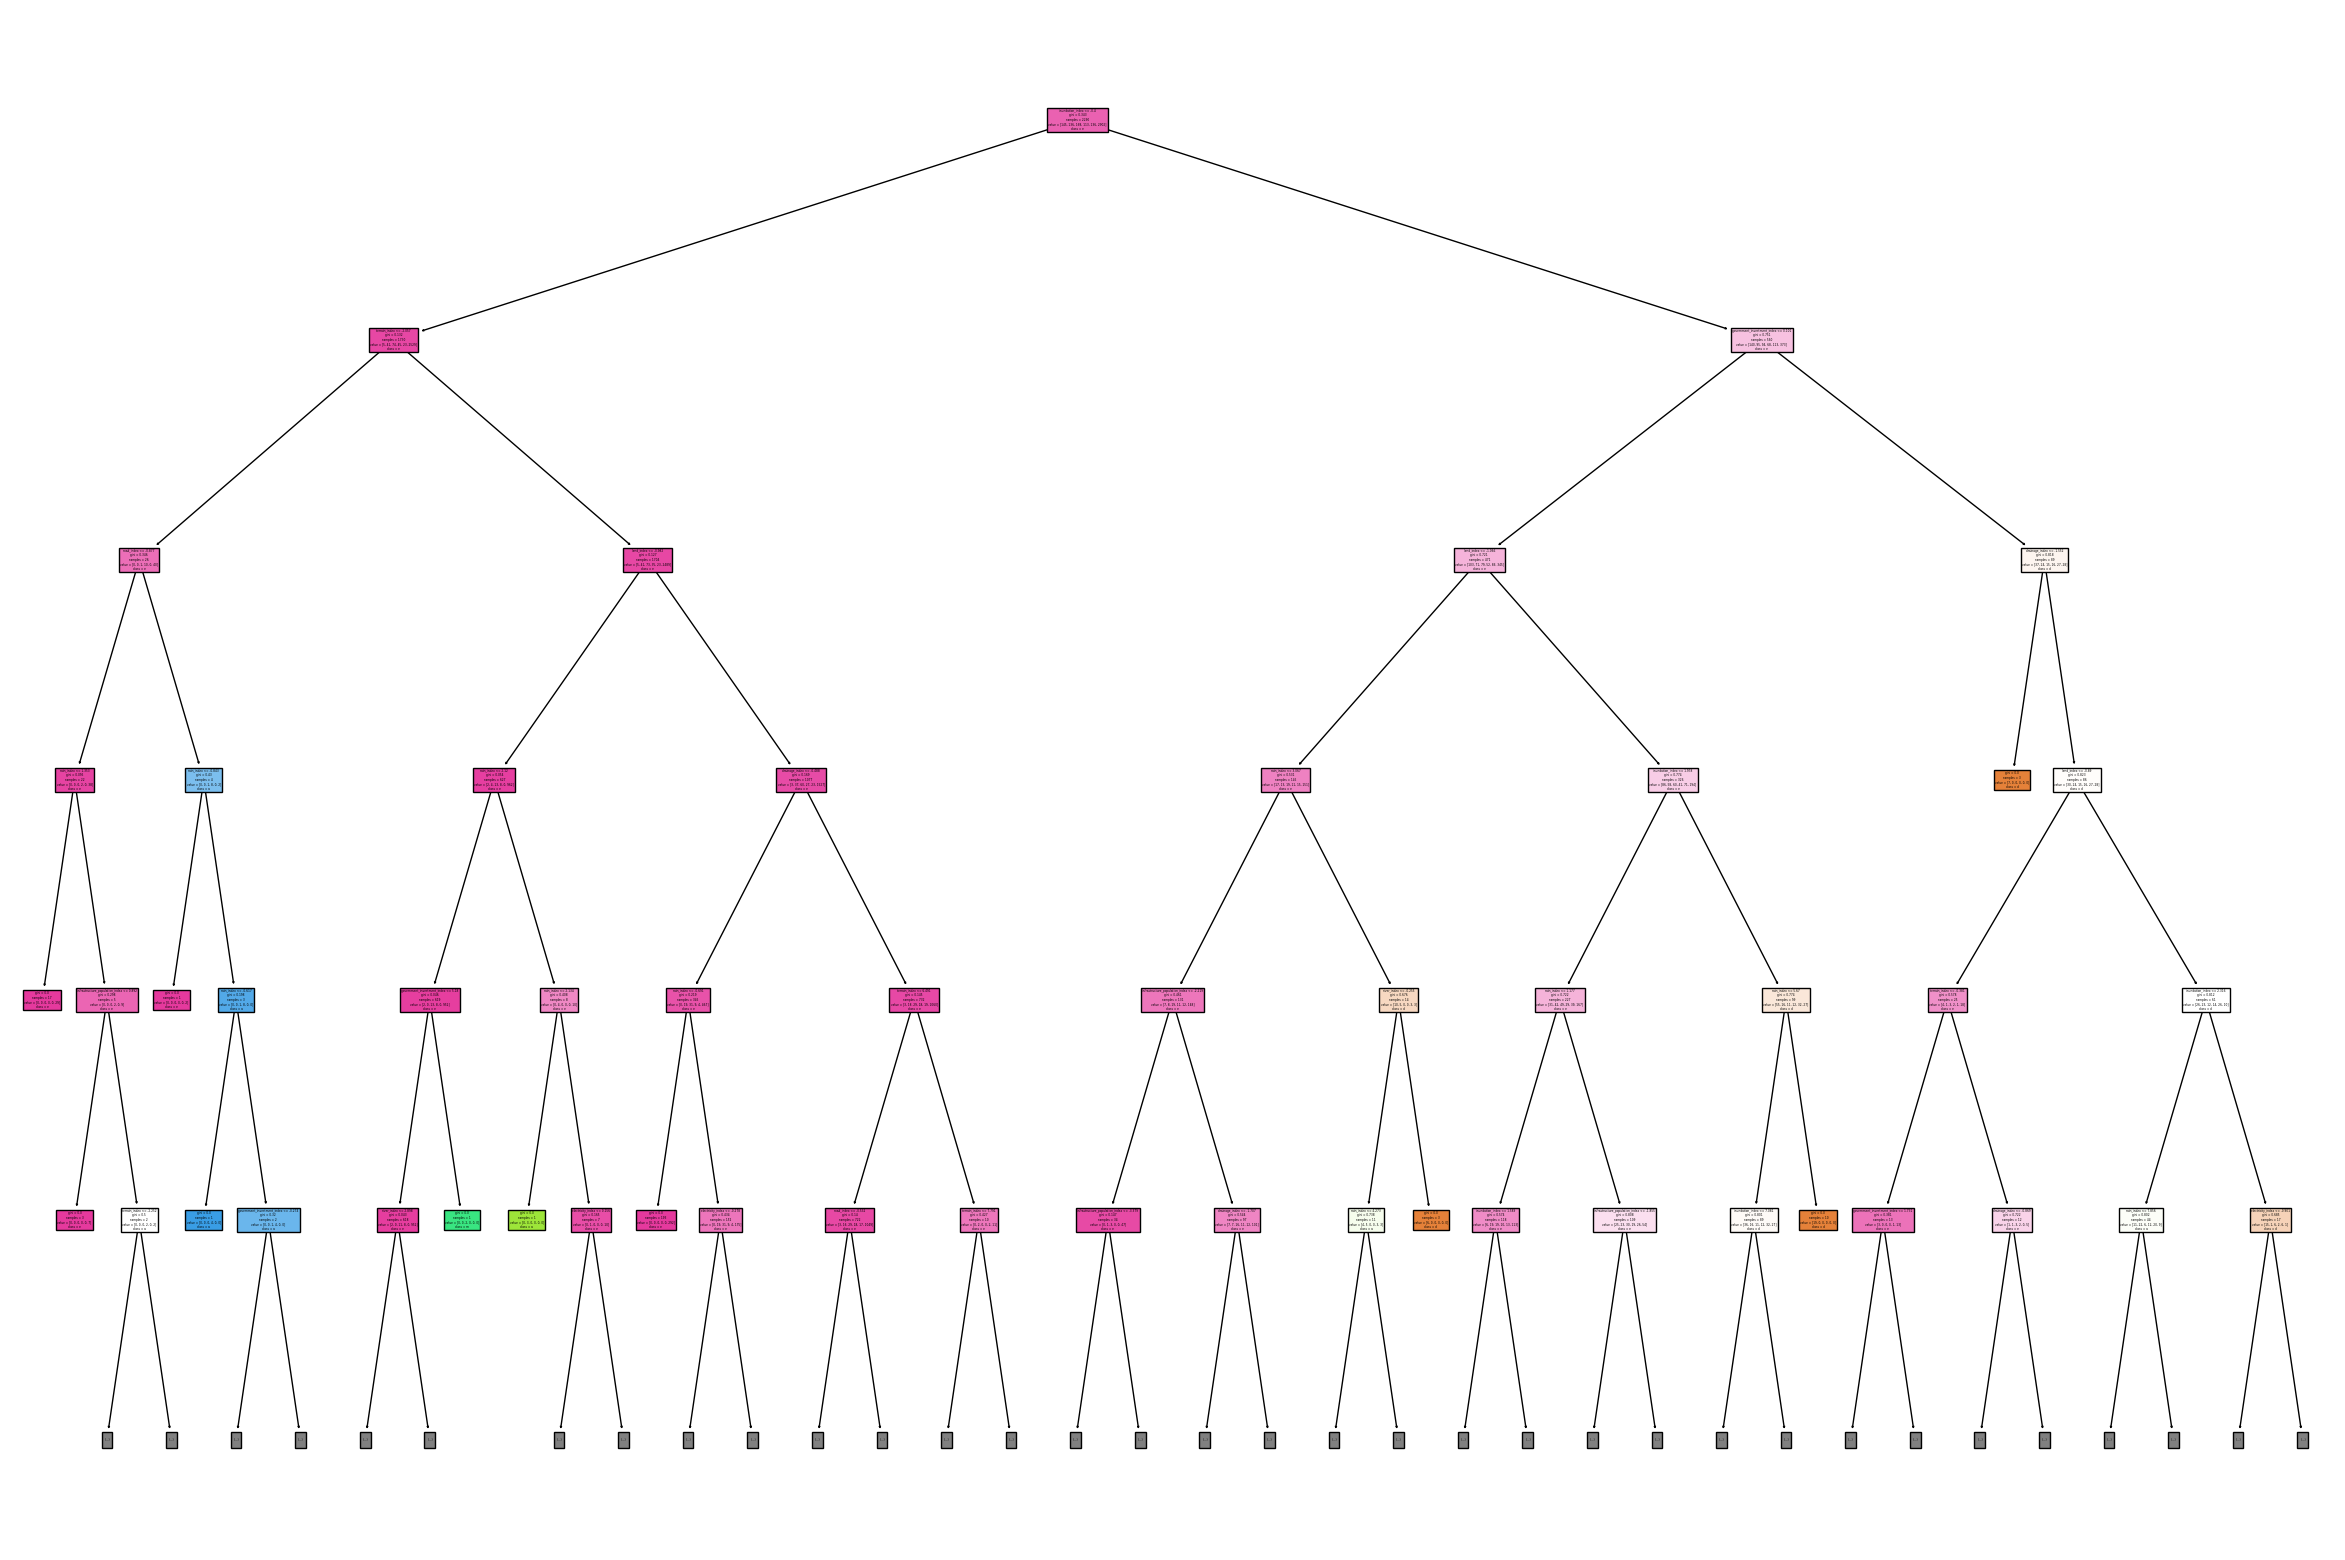

In [66]:
plt.figure(figsize=(30, 20))
tree.plot_tree(chosen_tree,
               feature_names=features,
               class_names=target,
               filled=True,
               max_depth=5)

# Save the plot as a PNG file with high DPI
plt.savefig("decision_tree.png", format="png", dpi=300)

# Show the plot
plt.show()

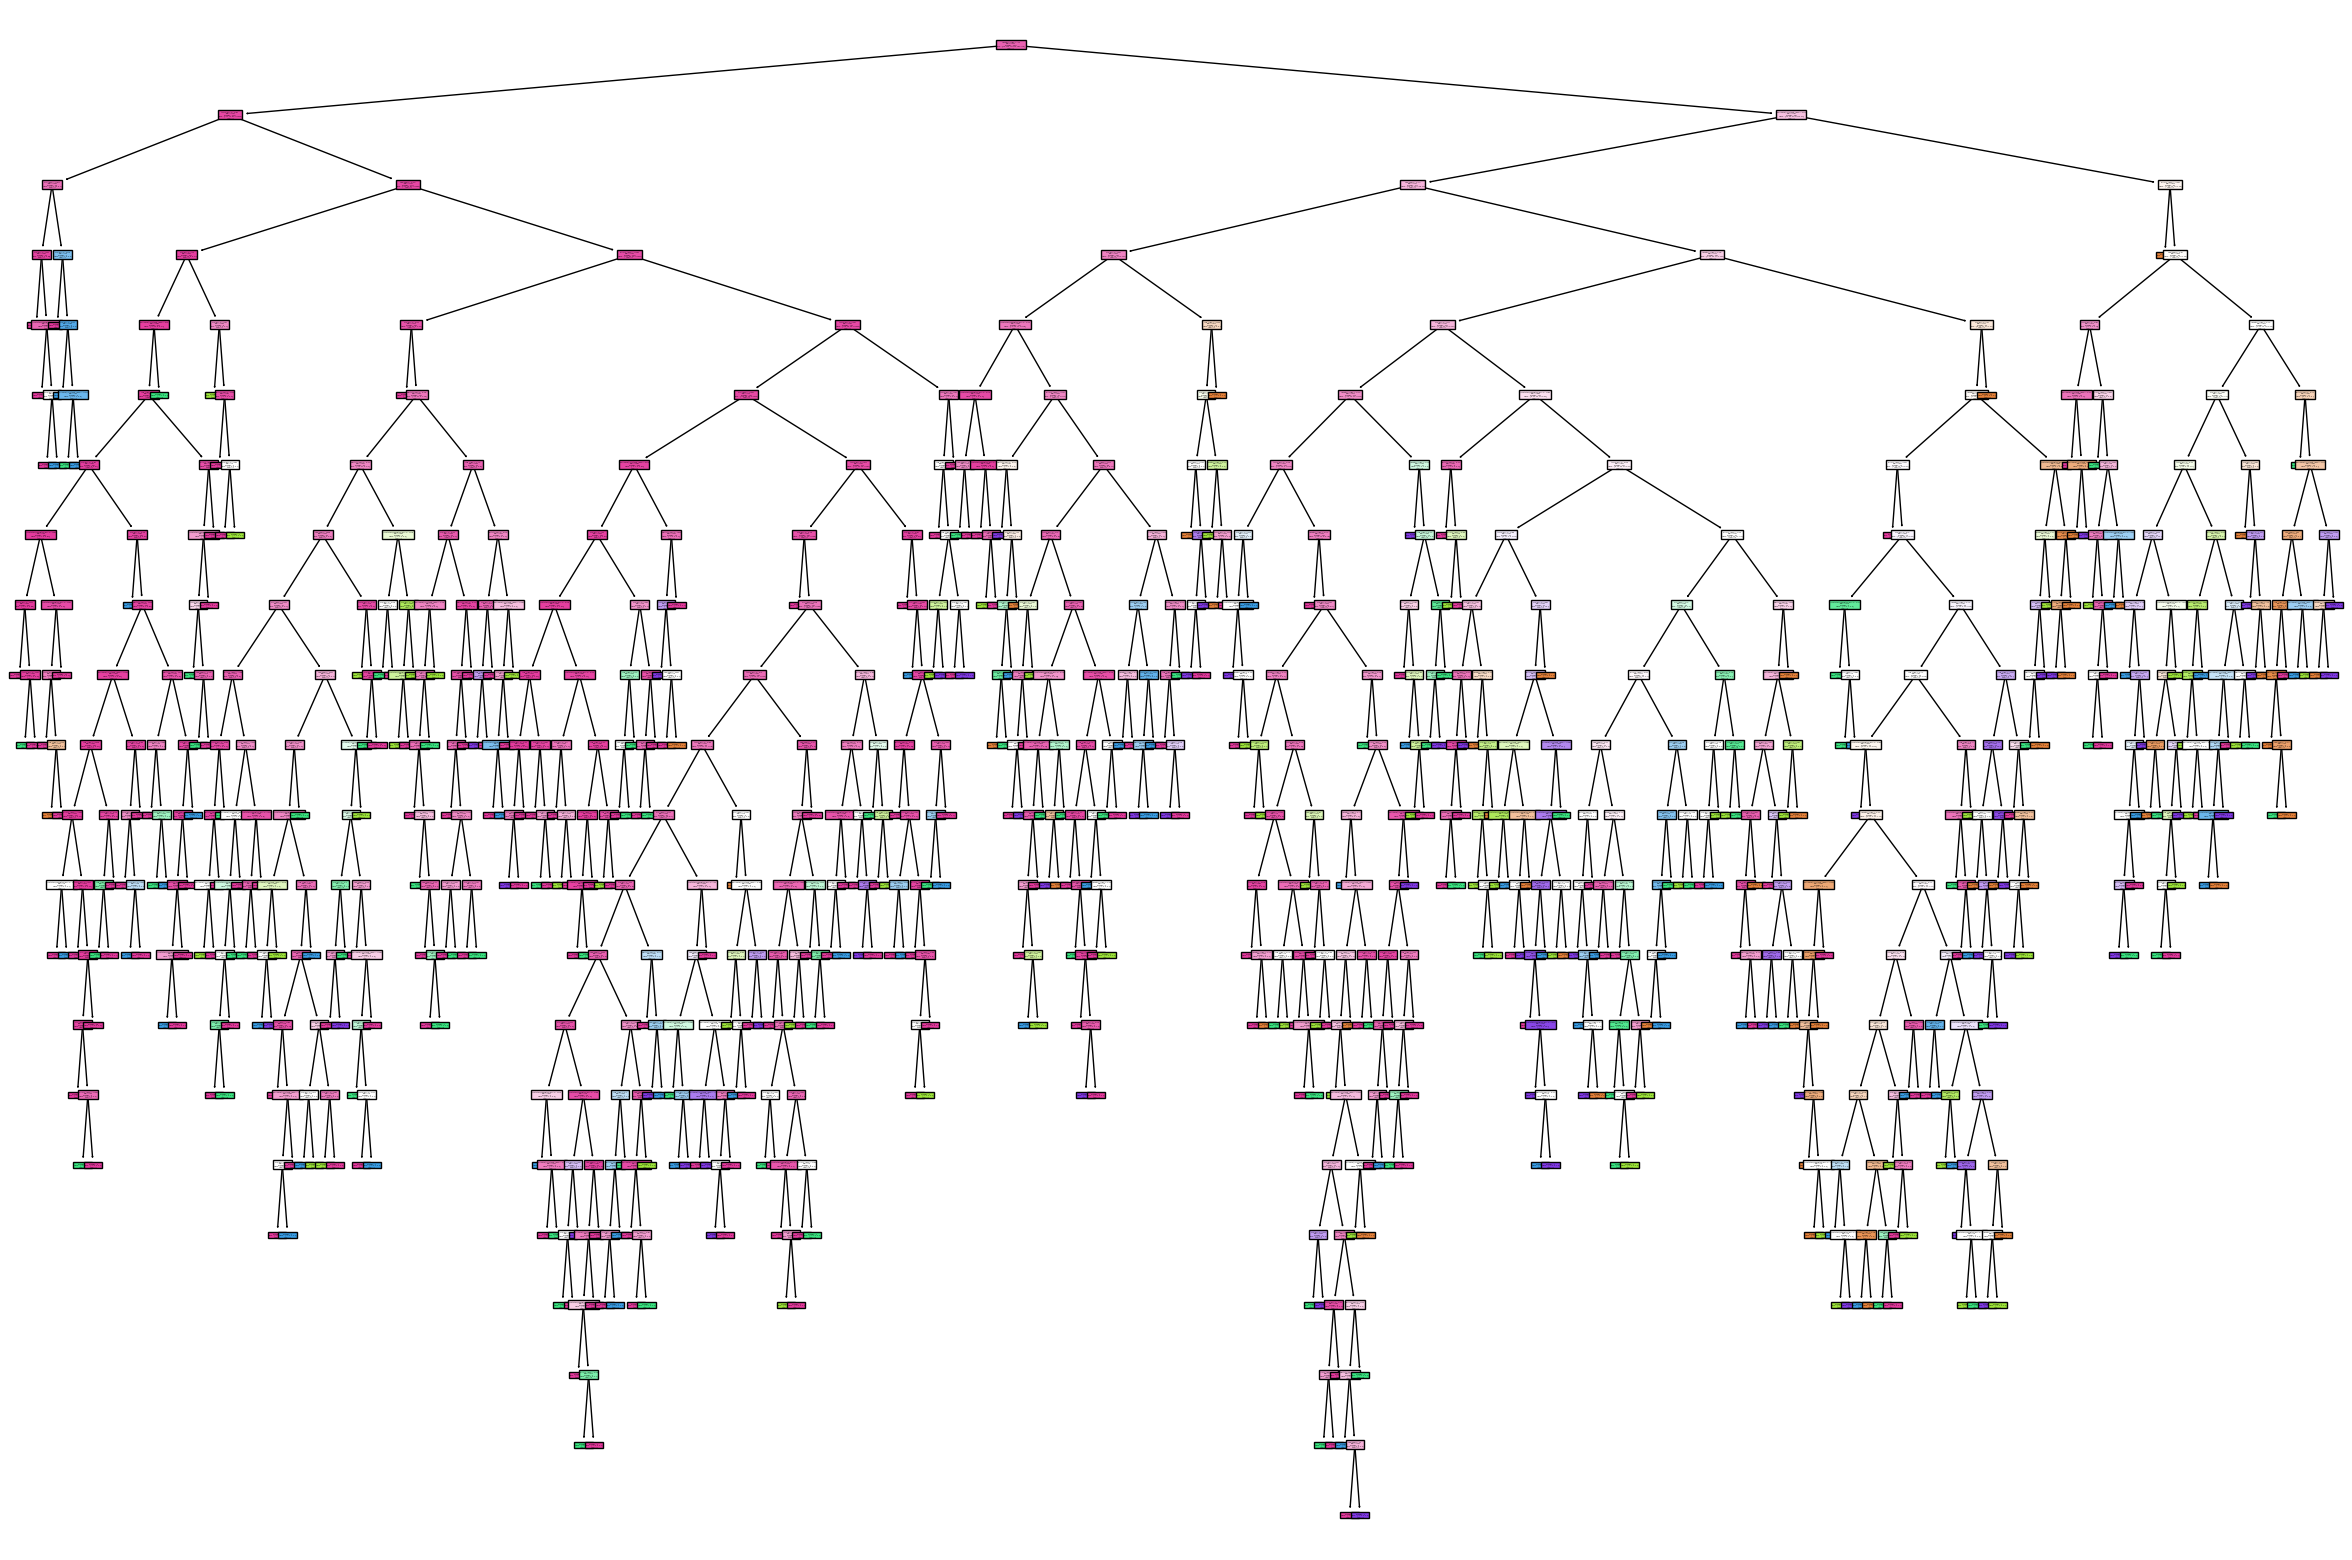

In [67]:
plt.figure(figsize=(30, 20))
tree.plot_tree(chosen_tree,
               feature_names=features,
               class_names=target,
               filled=True)

plt.show()

# Computing Flood Vulnerability Score

In [68]:
# Feature importance
importances = rf_classifier.feature_importances_

In [70]:
# Create a DataFrame for easier visualization
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

In [71]:
feature_importances

,Feature,Importance
1,inundation_index,0.226532
2,rain_index,0.225766
6,terrain_index,0.106123
4,infrastructure_population_index,0.080833
7,land_index,0.078198
8,drainage_index,0.075348
5,road_index,0.059240
9,electricity_index,0.058029
0,government_investment_index,0.050690
3,river_index,0.039243


flood_vulnerability score = (negative value of) terrain_index * 0.106123 + infrastructure_population_index * 0.080833 + land_index * 0.078198 + road_index * 0.059240 +electricity_index + 0.058029 + government_investment_index * 0.050690  (- damage_index * 1 - inundation_index * 0.226532 - rain_index * 0.225766 - river_index * 0.039243- drainage_index * 0.075348)

In [141]:
#define weights and decide negative effects
score_features = ['government_investment_index',
 'inundation_index',
 'rain_index',
 'river_index',
 'infrastructure_population_index',
 'road_index',
 'terrain_index',
 'land_index',
 'drainage_index',
 'electricity_index']

feature_importance = list(importances)
weights = dict(zip(score_features, feature_importance))
negtive_effects = ['inundation_index', 'rain_index', 'river_index', 'drainage_index']
for effects in negtive_effects:
    weights[effects] *= -1

weights['damage_index'] = -1
weights

{'government_investment_index': 0.05068962822127927,
 'inundation_index': -0.2265319809480134,
 'rain_index': -0.2257656189072557,
 'river_index': -0.03924264321472609,
 'infrastructure_population_index': 0.08083259368637923,
 'road_index': 0.05924037118153315,
 'terrain_index': 0.10612270464682699,
 'land_index': 0.07819783947643426,
 'drainage_index': -0.07534773650366697,
 'electricity_index': 0.05802888321388492,
 'damage_index': -1}

In [145]:
features = list(weights.keys())
score_factors = pca_factors_2[features].copy()

# Multiply each factor by its corresponding weight and sum to compute the score
for feature in features:
    score_factors[feature] *= weights[feature]

# Compute the weighted sum of factors for each observation to get the flood vulnerability score
score_factors['flood_vulnerability_score'] = score_factors.sum(axis=1)

In [146]:
#change the sign, higher the score is, higher the vulnerability is.
score_factors['flood_vulnerability_score'] = score_factors['flood_vulnerability_score'] * -1

In [147]:
score_factors

,government_investment_index,inundation_index,rain_index,river_index,infrastructure_population_index,road_index,terrain_index,land_index,drainage_index,electricity_index,damage_index,flood_vulnerability_score
0,0.008025,0.150730,0.043356,0.026082,0.274789,0.102627,-0.008499,-0.053341,-0.034269,-0.084335,0.267552,-0.692719
1,0.027819,0.150730,-0.887764,0.026082,0.274789,0.102627,0.014780,-0.053341,-0.034269,-0.084335,0.267552,0.195329
2,0.034770,0.150730,-0.849721,0.026082,0.274789,0.102627,0.041433,-0.053341,-0.034269,-0.084335,0.216676,0.174558
3,0.016530,-0.144907,-1.105924,0.026082,0.274789,0.102627,0.041433,-0.053341,-0.034269,-0.084335,0.267552,0.693762
4,-0.002962,-0.090380,-0.466339,0.026082,0.274789,0.102627,0.041433,-0.053341,-0.034269,-0.084335,0.216676,0.070018
...,...,...,...,...,...,...,...,...,...,...,...,...
5035,0.101347,0.150730,0.018123,0.026082,-0.075400,-0.103539,-0.177817,0.459509,-0.030343,0.035114,0.267552,-0.671359
5036,0.101347,0.150730,0.018123,0.026082,-0.075400,-0.103539,-0.171404,0.459509,-0.030343,0.035114,0.267552,-0.677772
5037,-0.015668,-0.044418,0.018123,0.026082,-0.075400,-0.103539,-0.229435,0.459509,-0.030343,0.035114,0.165052,-0.205078
5038,-0.015668,-0.196286,0.018123,0.026082,-0.075400,-0.103539,-0.229435,0.459509,-0.030343,0.035114,-0.271641,0.383483


In [162]:
quantiles = score_factors['flood_vulnerability_score'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
# Define labels for the six categories
labels = ['very low', 'low', 'medium', 'high', 'very high', 'extreme']

# Use the pd.cut function to categorize the scores based on the quantiles
score_factors['flood_vulnerability_category'] = pd.qcut(score_factors['flood_vulnerability_score'], 6, labels=labels)
# Check the first few entries in the new category column
score_factors[['flood_vulnerability_score', 'flood_vulnerability_category']].head(10)

,flood_vulnerability_score,flood_vulnerability_category
0,-0.692719,low
1,0.195329,very high
2,0.174558,very high
3,0.693762,extreme
4,0.070018,very high
5,-0.320751,high
6,-0.893727,very low
7,-0.977234,very low
8,-1.038017,very low
9,-0.915823,very low


In [165]:
score_factors['object_id'] = pca_factors_2['object_id']
score_factors['timeperiod'] = pca_factors_2['timeperiod']

In [166]:
#indices with weighted value and computed flood vulnerability score/category
score_factors

,government_investment_index,inundation_index,rain_index,river_index,infrastructure_population_index,road_index,terrain_index,land_index,drainage_index,electricity_index,damage_index,flood_vulnerability_score,flood_vulnerability_category,object_id,timeperiod
0,0.008025,0.150730,0.043356,0.026082,0.274789,0.102627,-0.008499,-0.053341,-0.034269,-0.084335,0.267552,-0.692719,low,101,2021_05
1,0.027819,0.150730,-0.887764,0.026082,0.274789,0.102627,0.014780,-0.053341,-0.034269,-0.084335,0.267552,0.195329,very high,101,2021_06
2,0.034770,0.150730,-0.849721,0.026082,0.274789,0.102627,0.041433,-0.053341,-0.034269,-0.084335,0.216676,0.174558,very high,101,2021_07
3,0.016530,-0.144907,-1.105924,0.026082,0.274789,0.102627,0.041433,-0.053341,-0.034269,-0.084335,0.267552,0.693762,extreme,101,2021_08
4,-0.002962,-0.090380,-0.466339,0.026082,0.274789,0.102627,0.041433,-0.053341,-0.034269,-0.084335,0.216676,0.070018,very high,101,2021_09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,0.101347,0.150730,0.018123,0.026082,-0.075400,-0.103539,-0.177817,0.459509,-0.030343,0.035114,0.267552,-0.671359,low,281,2023_04
5036,0.101347,0.150730,0.018123,0.026082,-0.075400,-0.103539,-0.171404,0.459509,-0.030343,0.035114,0.267552,-0.677772,low,281,2023_05
5037,-0.015668,-0.044418,0.018123,0.026082,-0.075400,-0.103539,-0.229435,0.459509,-0.030343,0.035114,0.165052,-0.205078,high,281,2023_06
5038,-0.015668,-0.196286,0.018123,0.026082,-0.075400,-0.103539,-0.229435,0.459509,-0.030343,0.035114,-0.271641,0.383483,extreme,281,2023_07


Next Steps:
Validate the result.
Can't compare to the random forest result because the way we set the threshold for 'very low' class. We applied the lowest value to be the 'very low' class, which is not the case here.